In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from matplotlib.image import imread
from collections import defaultdict

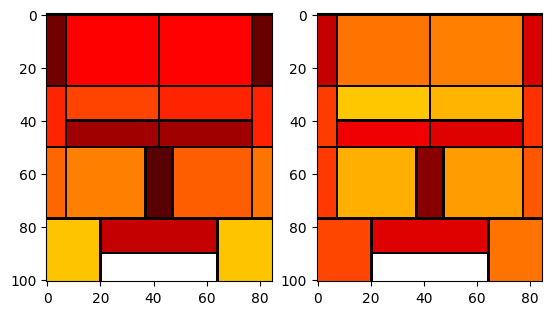

{8: 741, 6: 882, 1: 371, 14: 714, 19: 1332, 17: 250, 5: 713, 11: 412, 15: 834, 10: 424, 16: 799, 18: 423, 7: 458, 2: 606, 4: 629, 9: 845, 13: 659, 12: 587, 3: 599, None: 0}
{5: 789, 8: 805, 19: 2170, 14: 1429, 4: 1430, 2: 915, 13: 1168, 3: 1122, 1: 342, 15: 1210, 9: 915, 18: 607, 11: 313, 7: 484, 6: 1009, 16: 1099, 10: 491, 12: 900, 17: 257, None: 0}
{(5, 8): 129, (8, 6): 37, (5, 1): 73, (14, 14): 128, (14, 19): 208, (2, 1): 39, (13, 14): 104, (13, 17): 15, (3, 19): 92, (5, 5): 172, (8, 11): 87, (15, 15): 168, (19, 14): 216, (13, 10): 34, (9, 5): 41, (18, 16): 51, (4, 17): 15, (4, 18): 34, (11, 7): 7, (7, 1): 16, (5, 7): 19, (15, 6): 154, (6, 2): 54, (2, 6): 50, (6, 15): 66, (8, 5): 129, (7, 16): 35, (16, 16): 126, (13, 16): 95, (10, 11): 22, (18, 18): 58, (14, 4): 56, (4, 14): 64, (16, 9): 92, (9, 6): 106, (6, 10): 73, (12, 13): 59, (17, 8): 9, (8, 18): 3, (17, 5): 15, (19, 16): 50, (6, 17): 17, (19, 7): 10, (6, 1): 32, (12, 8): 30, (14, 1): 3, (11, 5): 21, (15, 19): 41, (14, 16): 63,

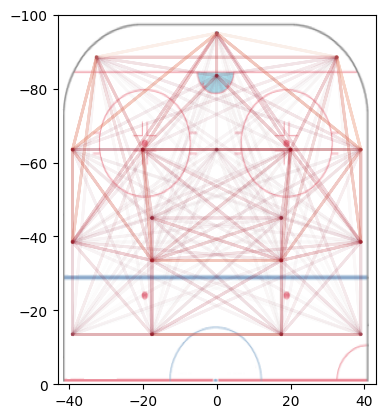

In [2]:
df = pd.read_csv(filepath_or_buffer="Linhac_df_keyed_20_games.csv")
"""
Idea: For each pass, we look at when the next shot occurs (or turnover, etc.)
    then we count the number of events till that other event, and then give that
    original event a decayed value for xG

    Then for the zone/bubble that the pass ocurred in, we add the new xG value to it

    Then we normalize by dividing the summed up xGs by the number of passes in that zones
"""

def get_zone(x, y):
    x = abs(x)

    if y > -43 and y < -35 and x < 27 and x > 0:
        return 1
    elif y > -43 and y < -35 and x < 50 and x > 27:
        return 2
    elif y > -43 and y < -35 and x < 77 and x > 50:
        return 3
    elif y > -43 and y < -22 and x > 77:
        return 4
    elif y > -35 and y < 0 and x < 27 and x > 0:
        return 5
    elif y > -35 and y < 0 and x < 40 and x > 27:
        return 6
    elif y > -35 and y < 0 and x < 50 and x > 40:
        return 7
    elif y > 0 and y < 35 and x < 27 and x > 0:
        return 8
    elif y > 0 and y < 35 and x < 40 and x > 27:
        return 9
    elif y > 0 and y < 35 and x < 50 and x > 40:
        return 10
    elif y > 35 and y < 43 and x < 27 and x > 0:
        return 11
    elif y > 35 and y < 43 and x < 50 and x > 27:
        return 12
    elif y > 35 and y < 43 and x < 77 and x > 50:
        return 13
    elif y > 22 and y < 43 and x > 77:
        return 14
    elif x > 50 and x < 77 and y > -35 and y < -5:
        return 15
    elif x > 50 and x < 77 and y > 5 and y < 35:
        return 16
    elif x > 50 and x < 77 and y > -5 and y < 5:
        return 17
    elif y > -22 and y < 22 and x > 77 and x < 90:
        return 18
    elif y > -22 and y < 22 and x > 90:
        return 19
    

def find_next_event():
    n = len(df)
    recv_locations = defaultdict(lambda: 0)
    pass_locations = defaultdict(lambda: 0)
    pass_vectors = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        if row['eventname'] == "pass" and idx != n - 1:
            nextplay = df.iloc[idx + 1]
            nexteventname = nextplay["eventname"]
            if nexteventname == "reception":
                recv_locations[
                    get_zone(
                        (nextplay["xadjcoord"]), 
                        (nextplay["yadjcoord"])
                    )
                ] += 1
                pass_vectors[(
                    get_zone(
                        row["xadjcoord"], 
                        row["yadjcoord"]
                    ),
                    get_zone(
                        nextplay["xadjcoord"], 
                        nextplay["yadjcoord"]
                    ))] += 1
            
            pass_locations[
                get_zone(
                    row["xadjcoord"], 
                    row["yadjcoord"]
                )
            ] += 1
    
    locs = [[pass_locations[get_zone(i, j)] for j in range(-42, 43)] for i in range(0, 101)]
    data = np.array(locs)
    recv_locs = [[recv_locations[get_zone(i, j)] for j in range(-42, 43)] for i in range(0, 101)]
    recv_data = np.array(recv_locs)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(data, cmap='hot', interpolation='nearest')
    ax[1].imshow(recv_data, cmap='hot', interpolation='nearest')
    plt.show()

    return (recv_locations, pass_locations, pass_vectors)

def map_passing_zones(pass_vectors: dict):
    zone_dict = {
        1: (13.5, -39),
        2: (38.5, -39),
        3: (63.5, -39),
        4: (88.5, -32.5),
        5: (13.5, -17.5),
        6: (33.5, -17.5),
        7: (45, -17.5),
        8: (13.5, 17.5),
        9: (33.5, 17.5),
        10: (45, 17.5),
        11: (13.5, 39),
        12: (38.5, 39),
        13: (63.5, 39),
        14: (88.5, 32.5),
        15: (63.5, -20),
        16: (63.5, 20),
        17: (63.5, 0),
        18: (83.5, 0),
        19: (95, 0),
    }

    zone_dict = {
        zone: (loc[1], -loc[0]) for zone, loc in zone_dict.items()
    }

    return {
        tuple(chain(*(zone_dict[zones[0]], zone_dict[zones[1]]))): freq
        for zones, freq in pass_vectors.items()
    }

res, pl, pv = find_next_event()
print(dict(res))
print(dict(pl))
print(dict(pv))
zones_dict = (map_passing_zones(dict(pv)))

def map_vectors(data):
    # Extract coordinates and frequencies
    x1_list = []
    y1_list = []
    x2_list = []
    y2_list = []
    frequency_list = []

    for (x1, y1, x2, y2), freq in data.items():
        x1_list.append(x1)
        y1_list.append(y1)
        x2_list.append(x2)
        y2_list.append(y2)
        frequency_list.append(freq)

    # Normalize frequencies
    min_freq = min(frequency_list)
    max_freq = max(frequency_list)
    norm = plt.Normalize(min_freq, max_freq)

    # Plot arrows with color and opacity based on frequency
    for i in range(len(x1_list)):
        color = plt.cm.RdBu(norm(frequency_list[i]))
        plt.arrow(x1_list[i], y1_list[i], x2_list[i] - x1_list[i], y2_list[i] - y1_list[i],
                head_width=0.1, head_length=0.2, linewidth=2, color=color, alpha=frequency_list[i]/max_freq)

    img = imread("hockey_rink.png")
    plt.imshow(img, extent=[-42.5, 42.5, -100, 0], alpha=0.5)  # adjust extent based on image size and scale


    # Set axis limits
    plt.xlim(-43, 43)
    plt.ylim(-100, 0)
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()


map_vectors(zones_dict)

In [3]:
def get_current_zone(x):
    return 0 if x >= 25 else (1 if x >= -25 and x < 25 else 2)

def is_ozone(x):
    return get_current_zone(x) == 0

def get_ozone_times(full_data: pd.DataFrame):
    games = sorted(full_data['gameid'].unique())
    gameDict = {}
    for game in games:
        game_df = full_data.loc[full_data['gameid'] == game].reset_index()
        curr_ozone_count = 0
        ozone_start_time = 0
        ozone_counts = defaultdict(list)
        cumul_xg = 0
        for i, event in game_df.iterrows():
            if not pd.isna(event['xg']):
                cumul_xg += event['xg']
            
            if event["teaminpossession"] is None:
                continue

            if i == 0:
                continue

            if event["teaminpossession"] == game_df.iloc[i - 1]["teaminpossession"] and is_ozone(event['xadjcoord']):
                if curr_ozone_count == 0:
                     ozone_start_time = event["compiledgametime"]
            
                curr_ozone_count += 1
            elif event["teaminpossession"] == game_df.iloc[i - 1]["teaminpossession"] and curr_ozone_count != 0:
                ozone_counts[event["teamid"]].append((event["compiledgametime"] - ozone_start_time, cumul_xg))
                curr_ozone_count = 0
                cumul_xg = 0
            elif event["teaminpossession"] == game_df.iloc[i - 1]["teaminpossession"]:
                continue
            else:
                if curr_ozone_count == 0:
                    continue

                if i != len(game_df) - 1 and game_df.iloc[i + 1]["teaminpossession"] == event["teaminpossession"]:
                    continue

                ozone_counts[event["teamid"]].append((event["compiledgametime"] - ozone_start_time, cumul_xg))
                curr_ozone_count = 0
                cumul_xg = 0
        gameDict[game] = ozone_counts
    
    return gameDict
gameDict = get_ozone_times(df)

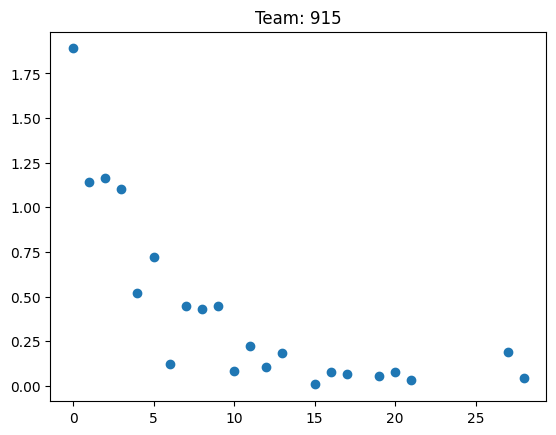

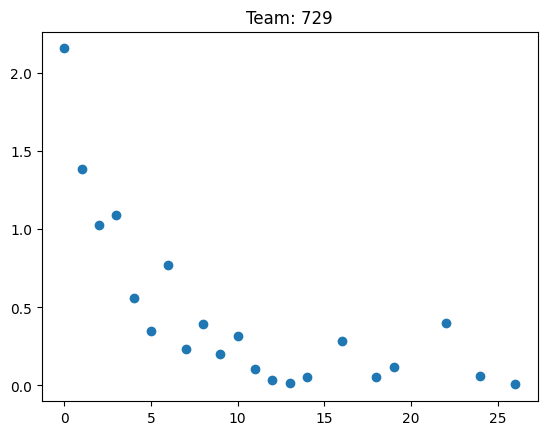

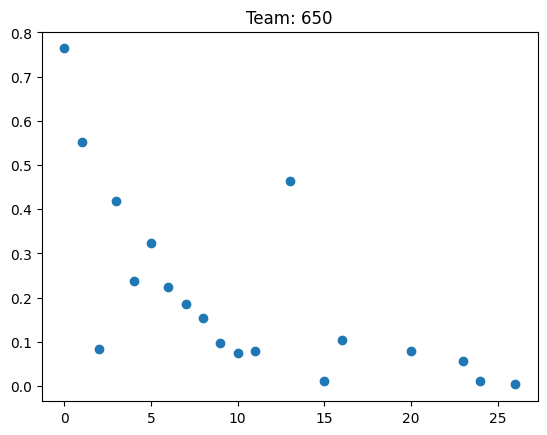

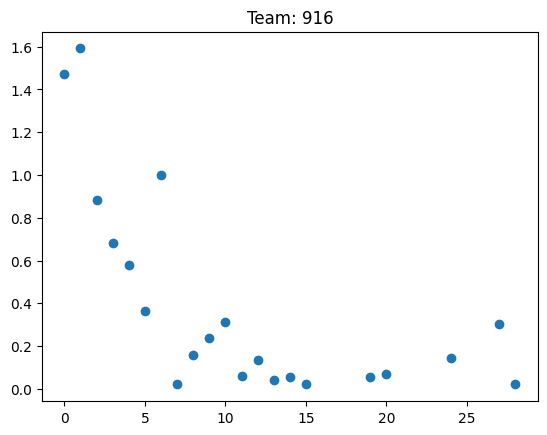

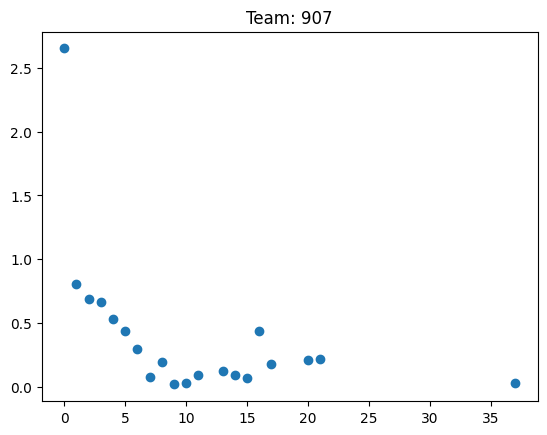

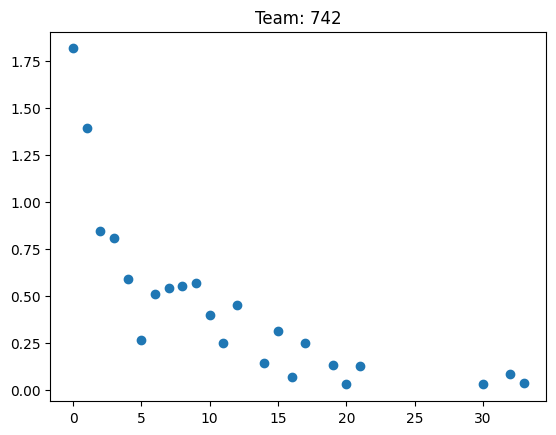

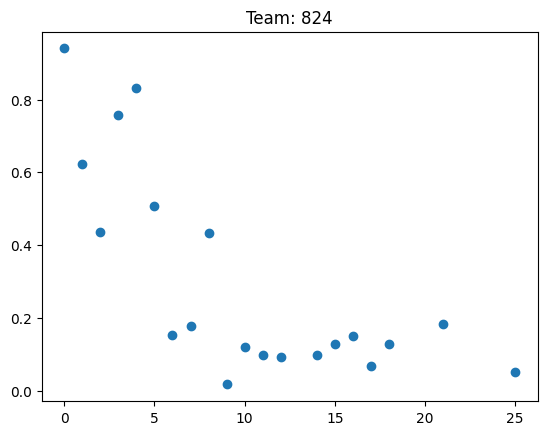

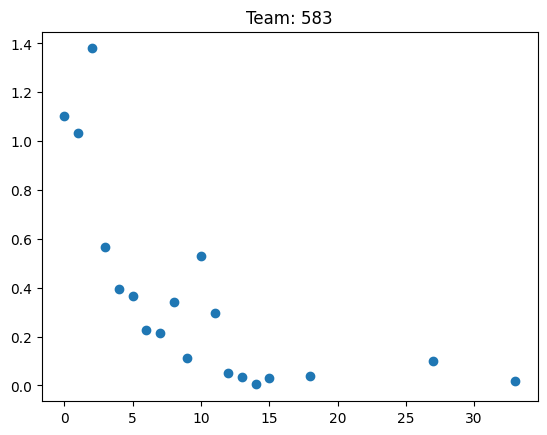

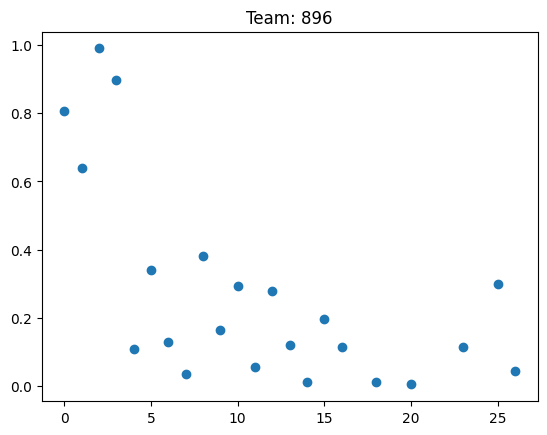

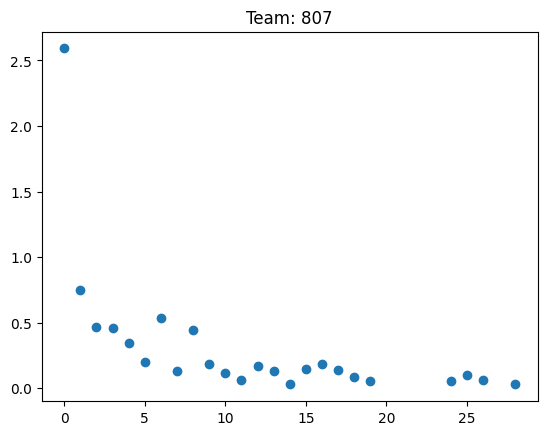

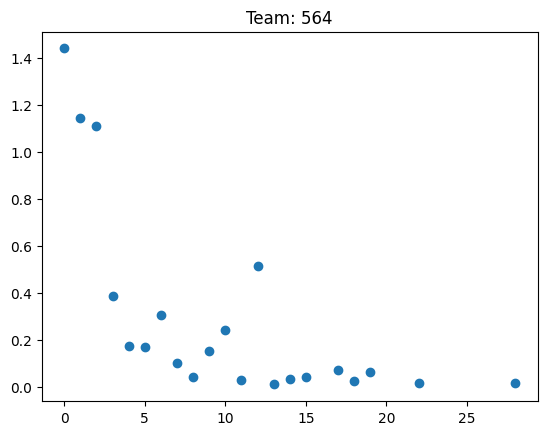

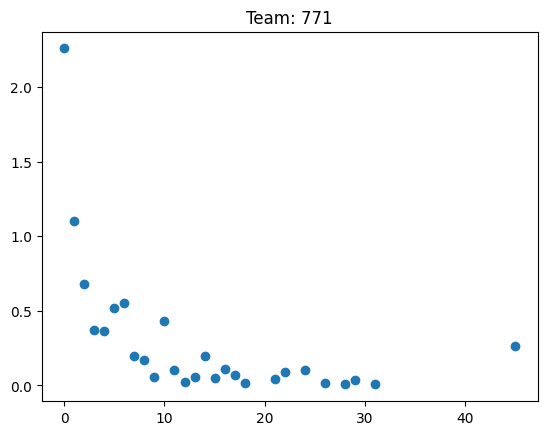

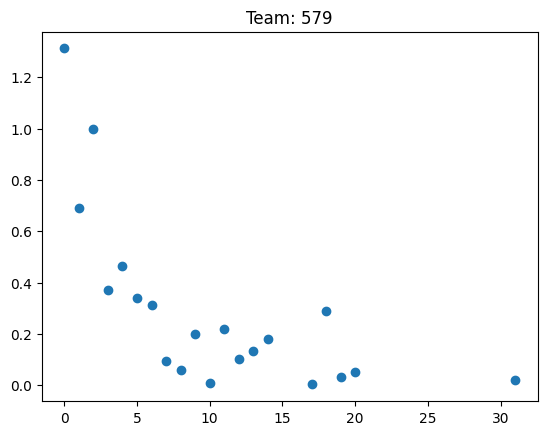

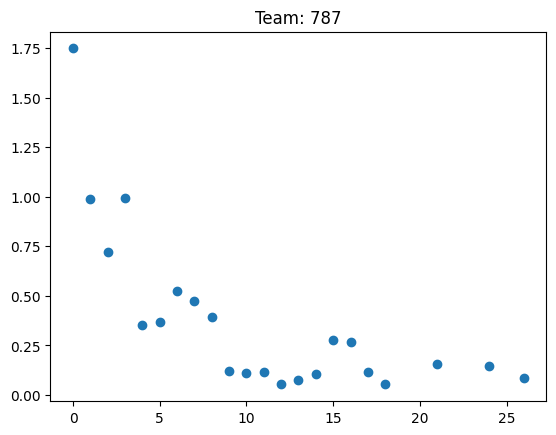

In [4]:
def collapseXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        totals[round(otime, 0)] += xg
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

for team in teamCount:
    data = np.array(collapseXGCount(teamCount[team]))
    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.show()


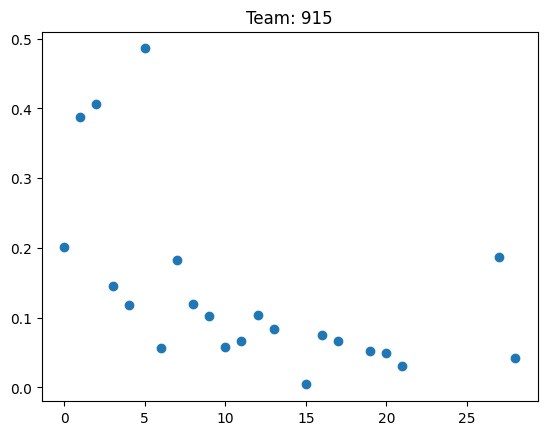

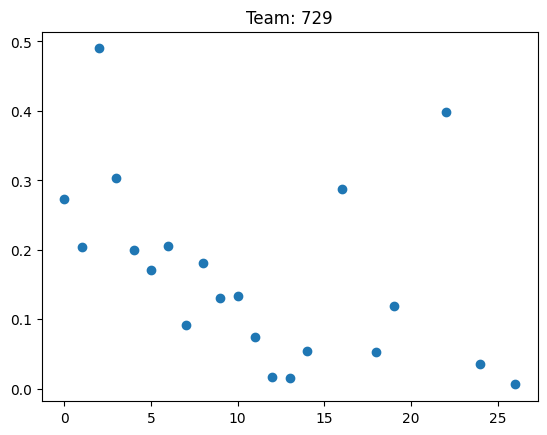

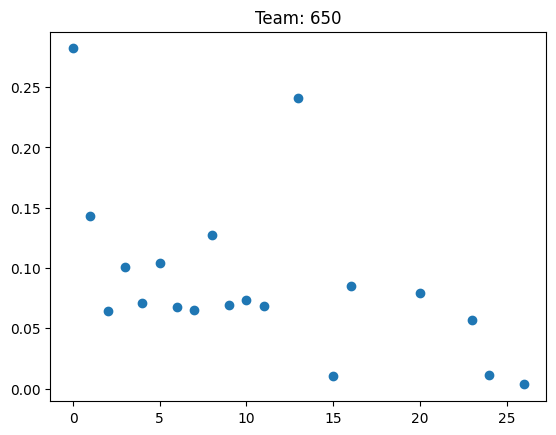

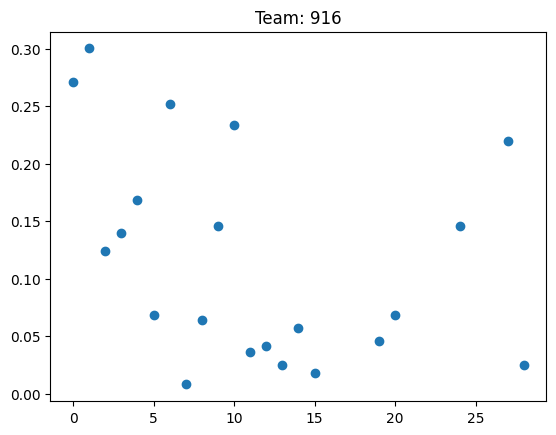

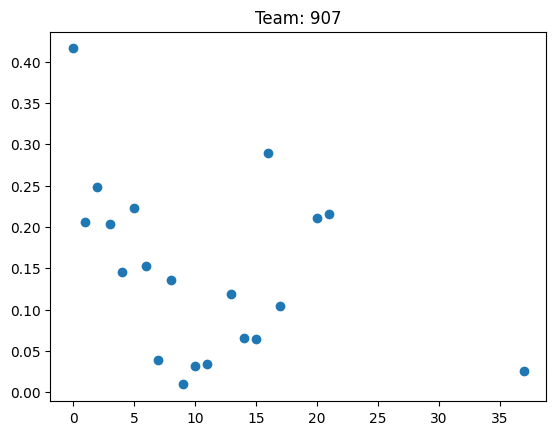

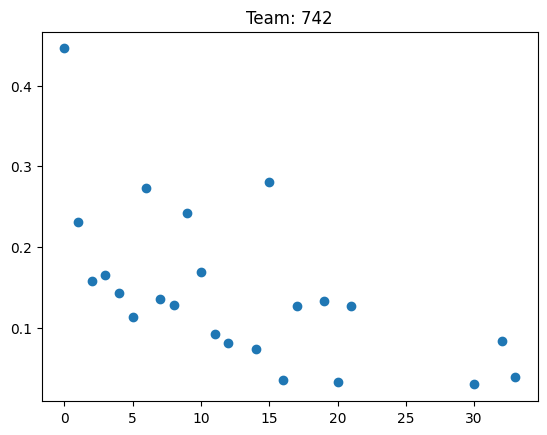

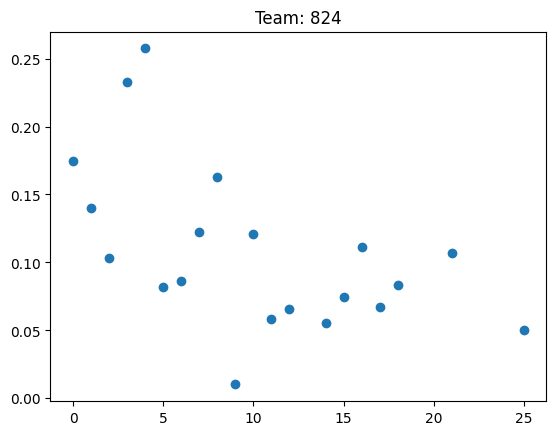

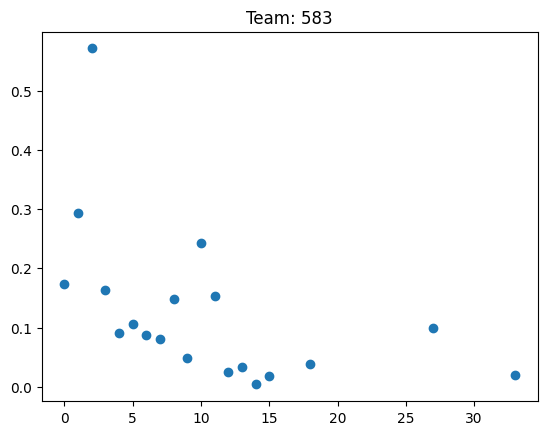

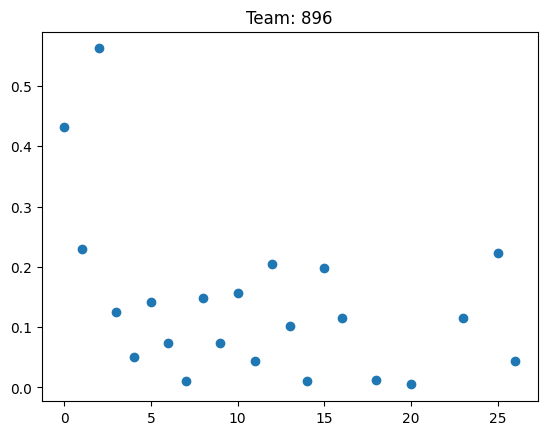

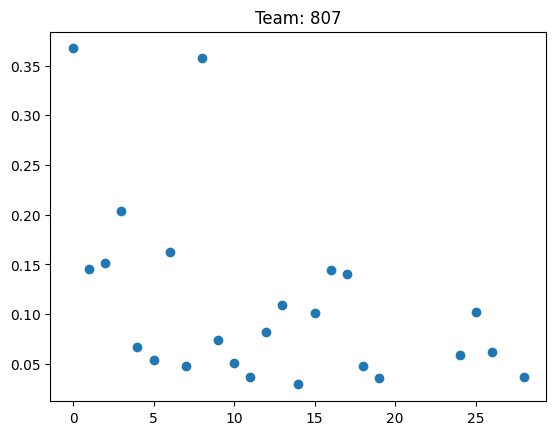

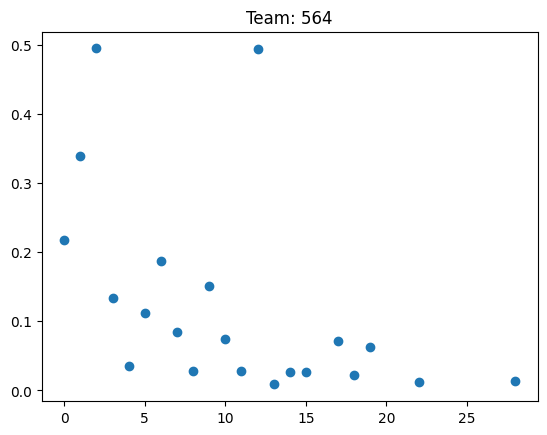

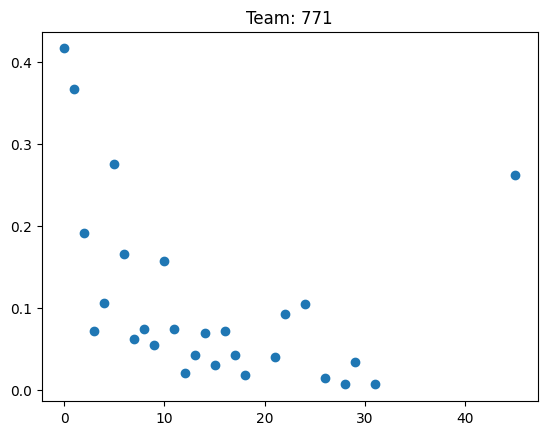

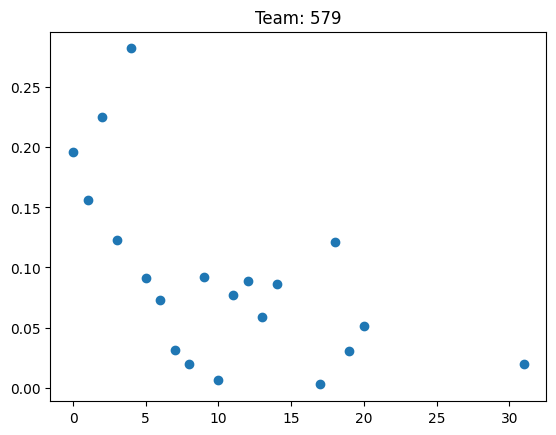

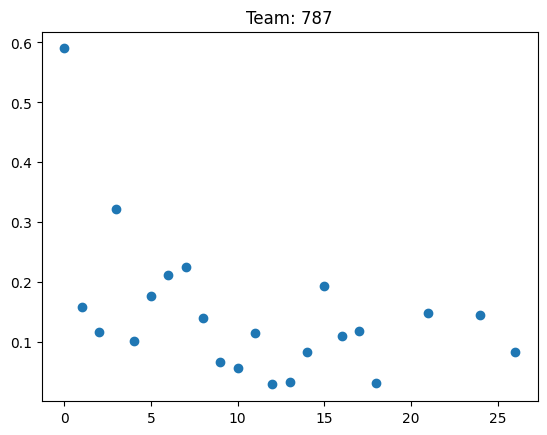

In [5]:
def collapseXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        totals[round(otime, 0)] = max(xg, totals[round(otime, 0)])
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

for team in teamCount:
    data = np.array(collapseXGCount(teamCount[team]))
    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.show()


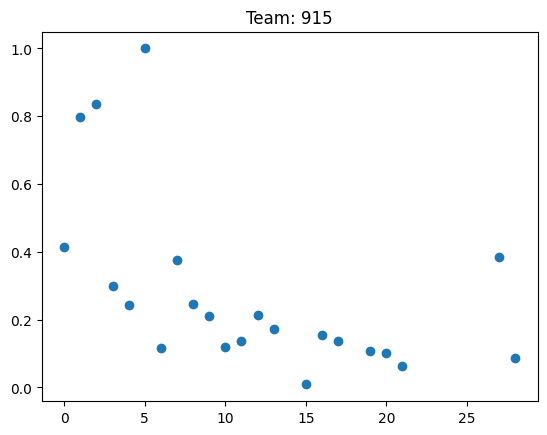

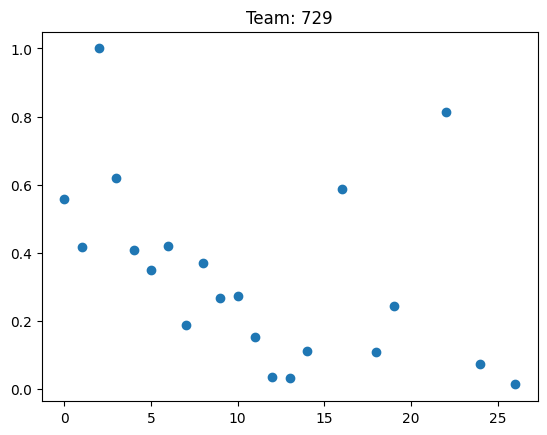

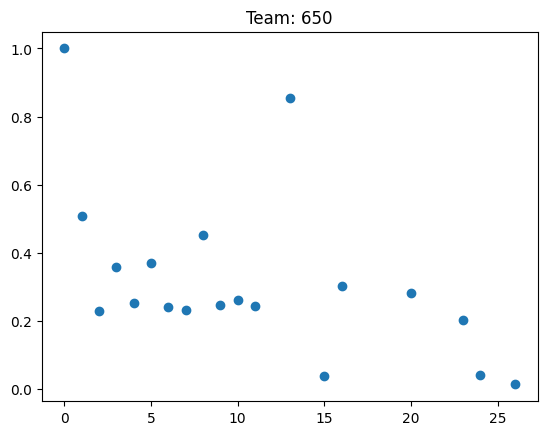

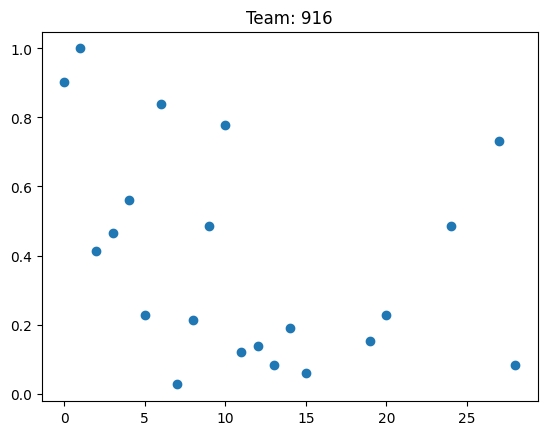

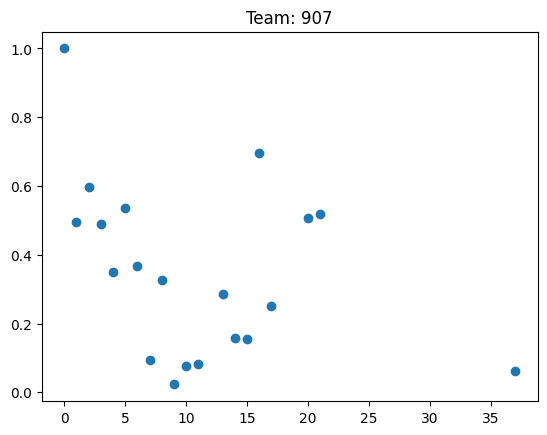

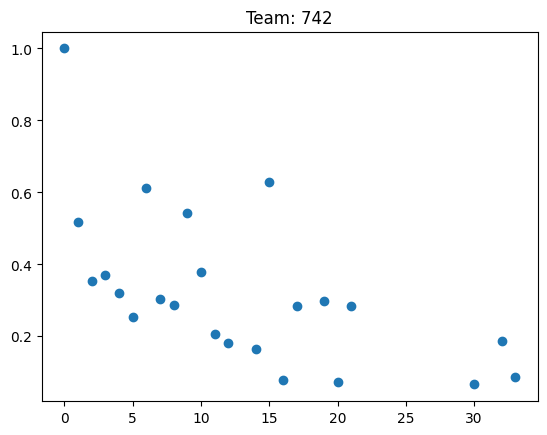

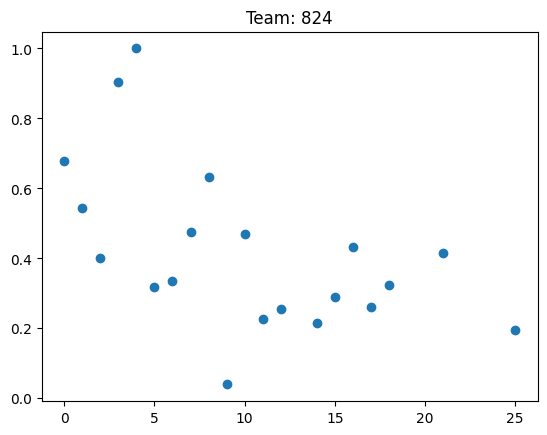

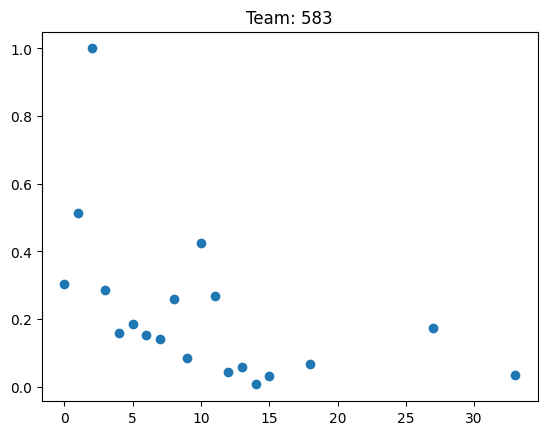

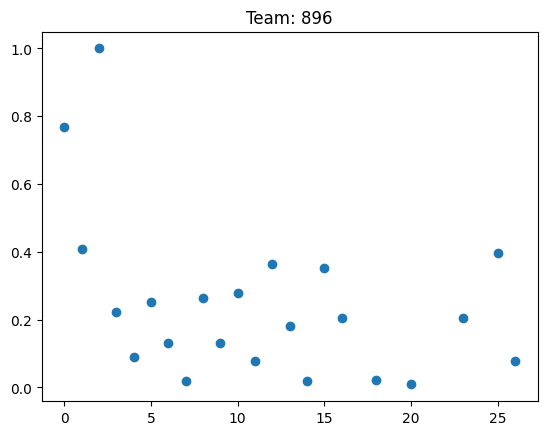

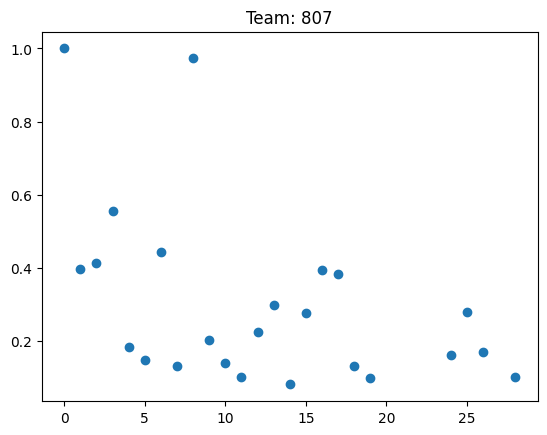

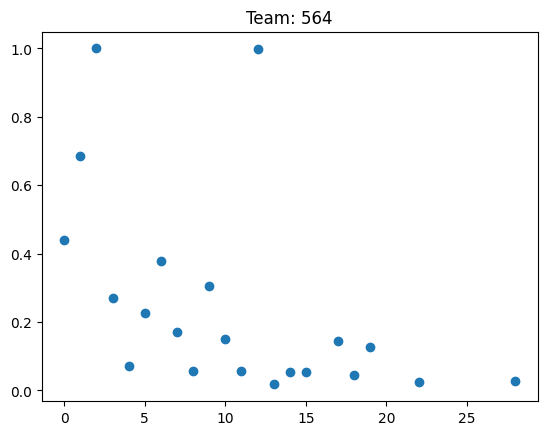

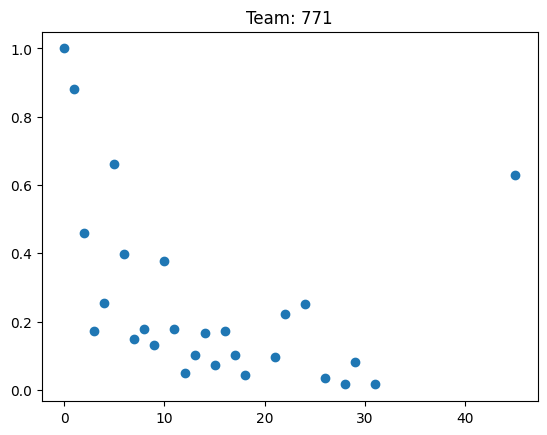

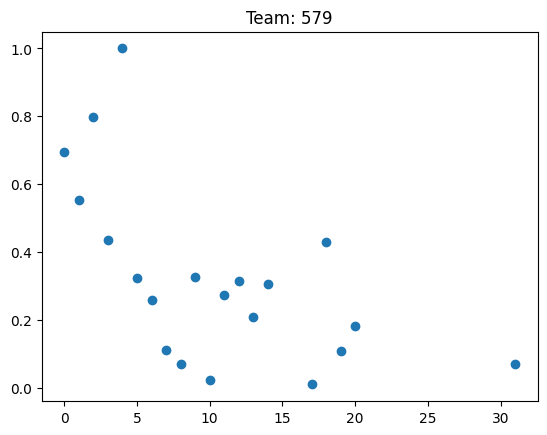

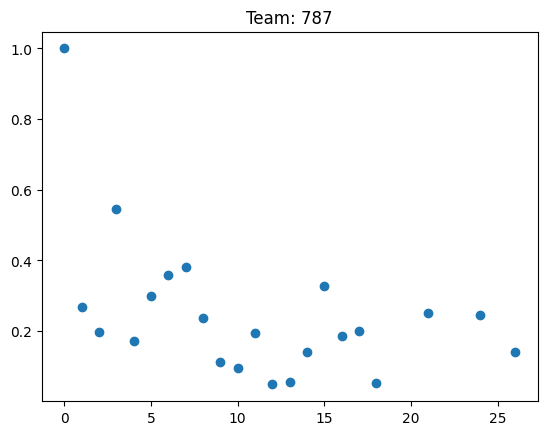

In [6]:
def collapseXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        totals[round(otime, 0)] = max(xg, totals[round(otime, 0)])
    
    maxSeen = max([val for val in totals.values()])
    return [[otime, (xg / maxSeen)] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

for team in teamCount:
    data = np.array(collapseXGCount(teamCount[team]))
    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.show()